In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

### **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Doc2Vec
- Begin modelling
    - Algorithms to use;
        - Simple Neural Network
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [3]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [4]:
df_clean.shape

(17340, 4)

In [5]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [6]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [7]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [8]:
df_clean.dropna(inplace=True)

In [9]:
df_clean.shape

(17337, 2)

In [10]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [11]:
# print(my_stop_words)

In [12]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [13]:
nlp = spacy.load("en_core_web_sm")

In [14]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [15]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [16]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [17]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [18]:
sentiment_mapping = {'negative':0,'neutral':1,'positive':2}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [19]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [20]:
df_clean

,tokens,sentiment_label
0,"[wish, get, early, love, make, work, laptop, e...",2
1,"[ve, learn, lesson, open, package, use, produc...",1
2,"[slow, lag, find, well, option]",1
3,"[roller, ball, stop, work, month, minimal, use...",1
4,"[like, color, size, day, return, period, not, ...",1
...,...,...
17335,"[love, speaker, love, charge, phone, work, no,...",2
17336,"[use, house, easy, connect, loud, clear, music]",2
17337,"[bass, good, battery, amazing, well, charge, t...",2
17338,[love],2


### **Text Sequencing**

In [21]:
X = df_clean["tokens"]

In [22]:
X[0]

['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy']

In [23]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)
X[0]

[153, 26, 758, 9, 124, 1, 51, 34]

In [24]:
# We need to find the maximum lenght of any document or review in our case. 
# We will pad all reviews to have this same length.
# This will be required by Keras embedding layer

review_max_length = 0
for i in df_clean['tokens']: 
    length = len(i)
    if length > review_max_length:
        review_max_length = length

print(review_max_length) 

# Although max length is 293, we will use an approximate value of 300; 
# maxlen = 300

293


In [25]:
# print(word_tokenizer.word_index) # Outputs a dictionary
len(word_tokenizer.word_index)

7258

In [26]:
vocab = word_tokenizer.word_index.items()

In [27]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

7259

In [28]:
max_len = 300
X = pad_sequences(X,padding="post",maxlen=max_len)

In [29]:
X[1].shape # shape
X[1].ndim # dimension

1

### **Doc2Vec Processing**

In [31]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [32]:
tagged_process = df_clean
# Tag train set 
tagged_process_train = tagged_process.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

In [33]:
tagged_process_train.values[0]

TaggedDocument(words=['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy'], tags=[2])

In [34]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores # Mine is 8 cores
four_cores = cores-4
four_cores

4

**Building the Vocabulary**

In [35]:
# dm=0, it signifies PV-DBOW
model_dbow= Doc2Vec(
    dm=0,
    vector_size=200,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5
)

# dm=1, it signifies PV-DM
model_dm = Doc2Vec(
    dm=1,
    vector_size=200,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5,
    dm_mean=1 # to make use of mean
)

In [36]:
model_dbow.build_vocab(tagged_process_train)
model_dm.build_vocab(tagged_process_train)

In [37]:
# PV-DBOW
model_dbow.train(
                tagged_process_train,
                total_examples=model_dbow.corpus_count,
                epochs=100,
)

# PV-DM
model_dm.train(
                tagged_process_train,
                total_examples=model_dm.corpus_count,
                epochs=100,
)

In [38]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec 
model_concat = ConcatenatedDoc2Vec([model_dbow,model_dm])

In [54]:
# model_concat.wv.get_vector("like").shape # vector shape 
# AttributeError: 'ConcatenatedDoc2Vec' object has no attribute 'shape'

# model_concat.wv.vector_size # vector size
# AttributeError: 'ConcatenatedDoc2Vec' object has no attribute 'wv'

# model_concat.dv.vector_size # vector size
# AttributeError: 'ConcatenatedDocvecs' object has no attribute 'vector_size'

In [55]:
# for i in model_concat.models:
#     print(i.vector_size) 
# 200, 
# 200

In [56]:
model_concat["like"].shape # 400

(400,)

In [60]:
# model_concat["like"] # prints out the vector

array([ 3.78130493e-03, -4.37936885e-03, -1.02478859e-03, -4.17379750e-04,
        2.97879335e-03, -3.70969949e-03, -6.59411540e-04, -3.47673288e-03,
        2.87635392e-03,  1.32282788e-03, -3.26192385e-05, -1.07072655e-03,
       -3.46825714e-03,  4.21852432e-03,  1.47661392e-03, -1.80843531e-03,
       -8.60629661e-04,  2.26180069e-03,  2.19564675e-03, -3.89006134e-04,
       -1.97099615e-03,  1.59951265e-03,  1.58232870e-03,  9.96953226e-04,
       -4.27147886e-03, -2.72160774e-04,  1.13919144e-03,  4.50061075e-03,
        2.55630614e-04, -1.57286401e-03,  5.57930442e-04, -3.22764507e-03,
       -4.09304630e-03,  1.78094034e-03,  4.86183539e-03,  3.46007524e-03,
        8.36617954e-04, -4.59746318e-03,  4.87971026e-03, -5.03673567e-04,
       -2.10336805e-03,  3.92487645e-03,  2.46402738e-03,  2.49618595e-03,
       -2.22246884e-03,  4.91807703e-03, -4.71324311e-04,  3.14137927e-04,
        2.50957441e-03,  1.59995677e-03, -3.27713019e-03, -1.97519711e-03,
       -1.38814445e-03,  

### **Creating Embedding Matrix**

In [61]:
d2v_vector_size  = 400
embedding_matrix = np.zeros((vocab_length, d2v_vector_size)) 
print(embedding_matrix.shape) # (7259, 400)
print(embedding_matrix.ndim) # 2-dimensional array

(7259, 400)
2


In [ ]:
embedding_matrix[:5,:2]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
# model_concat.wv.key_to_index.keys()
# # prints a list of keys like so dict_keys(['work', 'mouse', 'not', 'great',

In [62]:
# Because both model_dm and model_dbow are trained on the same document;
# We use them to check if the word is present in the keys()
# model_dm or model_dbow could be used in the if statement
# After the check we use model_concat to assign the corresponding vector size 
# which is a 400 vector space.
for word, index in vocab:
    if word in model_dm.wv.key_to_index.keys():
        embedding_matrix[index] = model_concat[word]
    else:
        embedding_matrix[index] = np.zeros(d2v_vector_size)

In [63]:
embedding_matrix[:10,:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.10749065e-03,  2.73956009e-03,  1.54571468e-03,
        -6.11215830e-04, -6.69847708e-04,  3.58597864e-03,
        -4.14054375e-03,  1.97368022e-03, -2.98530515e-03,
        -4.05822694e-03],
       [-1.33736490e-03,  4.08580666e-03, -4.93437037e-05,
         1.99707085e-03, -4.25825710e-04, -2.34130095e-03,
         2.64229416e-03,  4.69176332e-03, -2.36475165e-03,
         2.78750900e-03],
       [ 4.98027820e-03,  2.77404790e-03, -1.79582776e-03,
         4.71826363e-03, -6.93023185e-06,  7.41183749e-06,
        -6.63011684e-04, -3.56102525e-03,  4.34372434e-03,
        -4.86063724e-03],
       [ 1.16284075e-03,  2.78996350e-03,  2.39042938e-03,
        -3.65447812e-03,  3.26054869e-03,  3.60680220e-04,
        -1.76916597e-03,  1.42228600e-04,  4.66983439e-03,
         3.

### **Model Building**

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
y_nn = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')

In [66]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn,test_size=.2,random_state=42, 
                                            stratify=y_nn)

In [67]:
simple_nn = Sequential()
embedding_layer = Embedding(vocab_length,d2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)

# No hidden layer used
simple_nn.add(embedding_layer)
simple_nn.add(Flatten())
simple_nn.add(Dense(3,activation='softmax'))

In [68]:
simple_nn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(simple_nn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 400)          2903600   
_________________________________________________________________
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 360003    
Total params: 3,263,603
Trainable params: 360,003
Non-trainable params: 2,903,600
_________________________________________________________________
None


In [69]:
# Model training

simple_nn_history = simple_nn.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Epoch 1/10
87/87 [==============================] - 4s 45ms/step - loss: 0.7132 - acc: 0.7202 - val_loss: 0.6413 - val_acc: 0.7664
Epoch 2/10
87/87 [==============================] - 3s 38ms/step - loss: 0.4142 - acc: 0.8511 - val_loss: 0.6270 - val_acc: 0.7812
Epoch 3/10
87/87 [==============================] - 3s 36ms/step - loss: 0.3379 - acc: 0.8885 - val_loss: 0.6387 - val_acc: 0.7808
Epoch 4/10
87/87 [==============================] - 3s 39ms/step - loss: 0.2922 - acc: 0.9065 - val_loss: 0.6474 - val_acc: 0.7837
Epoch 5/10
87/87 [==============================] - 3s 36ms/step - loss: 0.2579 - acc: 0.9209 - val_loss: 0.6708 - val_acc: 0.7931
Epoch 6/10
87/87 [==============================] - 3s 36ms/step - loss: 0.2350 - acc: 0.9287 - val_loss: 0.6765 - val_acc: 0.7956
Epoch 7/10
87/87 [==============================] - 3s 36ms/step - loss: 0.2151 - acc: 0.9358 - val_loss: 0.6933 - val_acc: 0.7985
Epoch 8/10
87/87 [==============================] - 3s 38ms/step - loss: 0.1995 - a

In [70]:
# Predictions on the Test Set

score = simple_nn.evaluate(X_test, y_test, verbose=1)

109/109 [==============================] - 1s 7ms/step - loss: 0.7237 - acc: 0.8016


In [71]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.7237481474876404
Test Accuracy: 0.8016147613525391


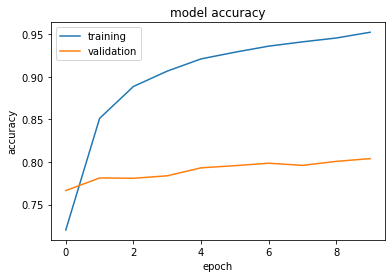

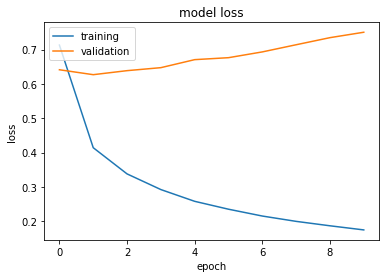

In [72]:
# Model Performance Charts

plt.plot(simple_nn_history.history['acc'])
plt.plot(simple_nn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(simple_nn_history.history['loss'])
plt.plot(simple_nn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

### **Classification report**

In [74]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred =   np.argmax(simple_nn.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.50      0.56       307
           1       0.75      0.77      0.76      1260
           2       0.85      0.87      0.86      1901

    accuracy                           0.80      3468
   macro avg       0.75      0.71      0.73      3468
weighted avg       0.80      0.80      0.80      3468



              precision    recall  f1-score   support

           0       0.65      0.50      0.56       307
           1       0.75      0.77      0.76      1260
           2       0.85      0.87      0.86      1901

    accuracy                           0.80      3468
   macro avg       0.75      0.71      0.73      3468
weighted avg       0.80      0.80      0.80      3468



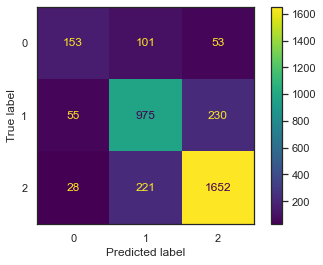

In [75]:
# Classification report test data

y_true=np.argmax(y_test, axis=1)
y_pred_test = simple_nn.predict(X_test)
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(simple_nn,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral --> 1
# positive --> 2

### **ROC Curve**

In [76]:
from sklearn.preprocessing import label_binarize

In [77]:
n_classes = 3

y_nn_auc = label_binarize(y_nn, classes=[0,1,2])

n_classes = y_nn_auc.shape[1]

In [78]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn_auc,test_size=.2,random_state=42, 
                                            stratify=y_nn_auc)

In [79]:
simple_nn = Sequential()
embedding_layer = Embedding(vocab_length,d2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)

# No hidden layer used
simple_nn.add(embedding_layer)
simple_nn.add(Flatten())
simple_nn.add(Dense(3,activation='softmax'))
simple_nn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(simple_nn.summary())
# Model training

simple_nn_history = simple_nn.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 400)          2903600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 360003    
Total params: 3,263,603
Trainable params: 360,003
Non-trainable params: 2,903,600
_________________________________________________________________
None
Epoch 1/10
87/87 [==============================] - 3s 40ms/step - loss: 0.7359 - acc: 0.7162 - val_loss: 0.6489 - val_acc: 0.7509
Epoch 2/10
87/87 [==============================] - 3s 35ms/step - loss: 0.4222 - acc: 0.8465 - val_loss: 0.6420 - val_acc: 0.7808
Epoch 3/10
87/87 [==============================] - 3s 37ms/step - loss: 0.3425 - acc: 0.8850 - val_l

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
fpr = {}
tpr = {}
roc_auc = {}
# Plot linewidth
lw = 2

# Version 2
classes_by_names = ["negative","neutral","positive"]
def roc_curve_plot(value,y_test):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], 
                                                    value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])                                                    
        plt.plot(fpr[i], tpr[i], lw=lw, label= "ROC of class {}, AUC= {}"
        .format(classes_by_names[i],np.round(roc_auc[i],2)))
        
       
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best",frameon=True) # ,labels=["negative","neutral","positive"]
    plt.title("ROC curve of Simple Neural Network multiclass; Sentiment prediction")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_test,value, multi_class="OvR",average='macro')
    print("AUC macro-averaged over all classes: {:.2f}"
    .format(roc_auc_scoring_macro_ovr))

In [81]:
y_pred_test = simple_nn.predict(X_test)
# y_pred_test=np.argmax(y_pred_test, axis=1)

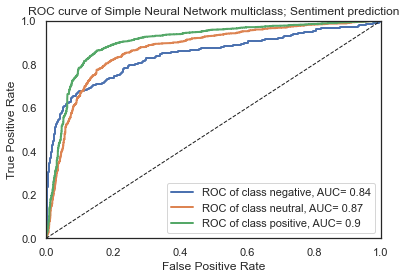

AUC macro-averaged over all classes: 0.87


In [82]:
roc_curve_plot(y_pred_test,y_test)

## **Conclusion**

Using the Simple Neral Network;
- PV-DBOW vector size of 200 had an f1 score of 0.25 and AUC score of 0.90 on test data
- PV-DM vector size of 200 had an f1 score of 0.73 and AUC score of 0.87 on test data
- Combining both methods does in fact gives a performance boost as shown in the table below. 
- It out performs PV-DBOW (AUC & f1-score) and has similar performance metrics as PV-DM-200.


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean (test data)|0.73|0.87